In [1]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit.quantum_info import OneQubitEulerDecomposer
from qiskit.quantum_info import TwoQubitBasisDecomposer
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.quantum_info.operators import Operator
from math import pi as PI

In [2]:
def oneQubitDecomppser(Gate):
    """
    Decomposes a single qubit gate to the Rx,Rz basis
    
    Parameters:
    Gate (qiskit Gate object): qiskit quantum gate object "https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.html".
    
    Returns:
    QuantumCircuit: Qiskit quantum circuit which contains the decomposition.
    """
    oneQubitDecomposer = OneQubitEulerDecomposer(basis="ZXZ")
    op=Operator(Gate)
    decomposition = oneQubitDecomposer.__call__(op)
    return decomposition

#testing

#qc=QuantumCircuit(1)
#qc.h(0)
#hgate=qc.data[0][0]
#oneQubitDecomppser(hgate).draw(output="mpl")


In [3]:
def twoQubitDecomppser(Gate):
    """
    Decomposes a two qubit gate to the Rx,Rz,cz basis
    
    Parameters:
    Gate (qiskit Gate object): qiskit quantum gate object "https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.html".
    
    Returns:
    QuantumCircuit: Qiskit quantum circuit which contains the decomposition.
    """
    twoQubitDecomposer=TwoQubitBasisDecomposer(gate=CZGate(), basis_fidelity=1.0, euler_basis="ZXZ")
    op=Operator(Gate)
    decomposition = twoQubitDecomposer.__call__(op)
    return decomposition

#testing

#qc=QuantumCircuit(2)
#qc.cx(0,1)
#cxgate=qc.data[0][0]
#twoQubitDecomppser(cxgate).draw(output="mpl")


In [4]:
def compiler(circuit):
    """
    Translates one quantum circuit into another, using a restricted set of gates {Rx,Rz,cz}.
    
    Parameters:
    circuit (QuantumCircuit): qiskit QuantumCirc
    uit object which contains the gates.
    
    Returns:
    QuantumCircuit: An equivalent quantum circuit which contains {Rx,Rz,cz} decomposition.
    """
    #initialize an empty circuit with the same size of qubits and clbits 
    decomposedCircuit = QuantumCircuit(circuit.num_qubits)
    if circuit.num_clbits >0:
        decomposedCircuit.add_register(ClassicalRegister(circuit.num_clbits))
    
    #extract the gates to compile them from the data list
    for item in circuit.data:
        
        #the gate object
        gate=item[0] 
        
        #number of qubits of the gate
        numOfQubits=len(item[1]) 
        
        #the indices that the gate applied on
        positions=[qubit.index for qubit in item[1]] 
        
        #check if the gate is a single qubit gate
        if numOfQubits==1:
            #decompose the single qubit gate
            decomposition=oneQubitDecomppser(gate)
            #extract the decomposition gates from the received circuit
            gates=[item[0] for item in decomposition.data]
            #append each gate to the new circuit at the same position    note: len(positions)=1 "single qubit gate"
            [decomposedCircuit.append(gate,positions) for gate in gates]
        
        #check if the gate is a two qubit gate
        elif numOfQubits==2:
            #decompose the gate
            decomposition=twoQubitDecomppser(gate)
            #extract the decomposition gates from the received circuit
            for item in decomposition.data:
                gate=item[0]
                if len(item[1])==2:
                    #append each gate to the new circuit at the same positions   note: len(positions)=2
                    decomposedCircuit.append(gate,positions)
                else:
                    #append a single qubit gate to the new circuit
                    #get the index (0 or 1) means the gate is applied to the 1st qubit or the 2nd qubit from the positions list 
                    decomposedCircuit.append(gate,[positions[item[1][0].index]])                 
    
    return decomposedCircuit

#testing
#qc=QuantumCircuit(5)
#qc.cx(0,1)
#qc.h(2)
#qc.rz(3.14,2)
#qc.h(2)
#qc.cz(3,4)
#qc.cz(3,4)
#qc.cz(3,4)
#qc.cz(3,4)
#print(qc)
#newCircuit=compiler(qc)
#newCircuit.draw(output="mpl")

In [5]:
#overhead
#1.rotations with zero angles
#2.double rotation about the same axis (we can combine them)
#3.doublicate cz gates (remove each other)

In [6]:
def removeZeroRotations(circuit):
    """
    Removes rotations with zero or 2PI angles.
    
    Parameters:
    circuit (QuantumCircuit): circuit before simplification.
    
    Returns:
    QuantumCircuit: A quantum circuit without gates with zero rotation.
    """
    n=len(circuit.data)
    i=0
    while i<n:
        angle=circuit.data[i][0].params
        if angle==[0.0] or angle==[2*PI]:
            circuit.data.pop(i)
            i=i-1
            n=n-1
        i=i+1
    return circuit


#testing
#newCircuit=removeZeroRotations(newCircuit)
#newCircuit.draw(output="mpl")

In [7]:
def removeDoubleCZ(circuit):
    """
    Removes pairs of cz at the same positions to optimize the circuit.
    
    Parameters:
    circuit (QuantumCircuit): circuit before simplification.
    
    Returns:
    QuantumCircuit: A quantum circuit after simplification.
    list: A list of stacks for wires, every stack contains the names of the gates that applied to that wire.
          To help for simplification later.
    """
    #initialize a stack for every wire to store the gates
    wires=[[""] for i in range(circuit.num_qubits)]
    n=len(circuit.data)
    i=0
    while i<n:
        #finds the cz gates in the data list
        if circuit.data[i][0].name=="cz":
            qubit1=circuit.data[i][1][0].index
            qubit2=circuit.data[i][1][1].index
            #check if there exist another cz gate before this at the same positions
            if wires[qubit1][-1][:2]=="cz" and wires[qubit2][-1][:2]=="cz":
                #delete the two adjacent cz gates
                circuit.data.pop(i)
                circuit.data.pop(int(wires[qubit1][-1][2:]))
                wires[qubit1].pop()
                wires[qubit2].pop()
                #redirect the index after deleting 2 nodes
                i=i-2
                n=n-2
            else:
                #adding cz gate to the stacks concatenated with the index of the instruction 
                #to use it for deleting if we found another cz gate at the same positions later
                wires[qubit1].append("cz"+str(i))
                wires[qubit2].append("cz"+str(i))
        else:
            #adding any other gate to the stacks
            qubit=circuit.data[i][1][0].index
            wires[qubit].append(circuit.data[i][0].name+str(i))
        i=i+1
        #print(wires)
    return circuit,wires

#testing
#newCircuit,wires=removeDoubleCZ(newCircuit) 
#newCircuit.draw(output="mpl")

In [8]:
def combineRotations(circuit,wires):
    """
    Combines the consecutive rotations about the same axis to optimize the circuit.
    
    Parameters:
    circuit (QuantumCircuit): circuit before simplification.
    wires (list): A list of stacks for wires, every stack contains the names of the gates that applied to that wire.
    
    Returns:
    QuantumCircuit: A quantum circuit after simplification.
    """
    #initialize a list to store the indices that will be deleted after the loop to not affect the stored sequence of indices
    indicesToPop=[]
    for j in range(len(wires)):
        i=0
        n=len(wires[j])
        while i<n-1:
            #checking if there exists a consecutive rotation gate about the same axis
            if wires[j][i][:2]==wires[j][i+1][:2]:
                
                #getting the instruction index that stored in the wires list 
                index1=int(wires[j][i][2:])
                index2=int(wires[j][i+1][2:])
                
                #getting the two angles of rotations to combine them
                angle1=circuit.data[index1][0].params[0]
                angle2=circuit.data[index2][0].params[0]
                Sum=angle1+angle2
                
                #combining the two angles in one gate and delete the other gate
                circuit.data[index2][0].params[0]=Sum
                indicesToPop.append(index1)
                
                #update the wires list data and redirect the i index 
                del wires[j][i]
                n=n-1
                i=i-1
                
                #checking if the combination of the angles equals 2PI (rotate and back to the same position)
                if round(Sum,2)==round(2*PI,2):
                    indicesToPop.append(index2)
                    
                    #delete the 2PI rotation and redirect the i index
                    del wires[j][i+1]
                    n=n-1
                    i=i-2
                
            i=i+1
            
    #sorting the indices in descending order to pop the biggest index first
    indicesToPop=sorted(indicesToPop, reverse=True)
    #removing the elements
    [circuit.data.pop(i) for i in indicesToPop]
    
    return circuit
    
#testing
#newCircuit=combineRotations(newCircuit,wires)
#newCircuit.draw(output="mpl")

In [9]:
def simplify(circuit):
    """
    Simplifies the circuit by removing the overhead that appears after decomposition.
    Overhead
    1.rotations with zero angles
    2.double rotation about the same axis (we can combine them)
    3.doublicate cz gates (remove each other)
    
    Parameters:
    circuit (QuantumCircuit): circuit before simplification.
    
    Returns:
    QuantumCircuit: A quantum circuit after simplification.
    """
    circuit=removeZeroRotations(circuit)
    circuit,wires=removeDoubleCZ(circuit)
    circuit=combineRotations(circuit,wires)
    return circuit

#testing
#newCircuit=simplify(newCircuit)
#newCircuit.draw(output="mpl")

# Using the Functions

## Circuit Creation

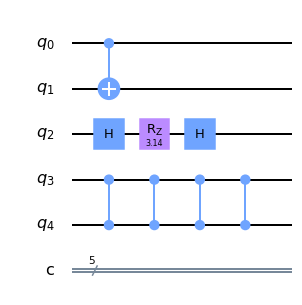

In [10]:
#create a quantum circuit
c1=QuantumCircuit(5,5)

#adding any gates
c1.cx(0,1)
c1.h(2)
c1.rz(3.14,2)
c1.h(2)
c1.cz(3,4)
c1.cz(3,4)
c1.cz(3,4)
c1.cz(3,4)

c1.draw(output="mpl")

## Circuit Decomposition

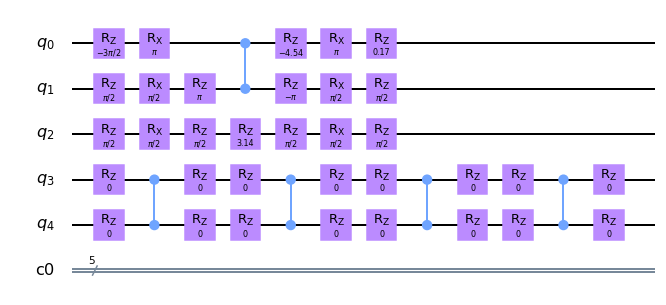

In [11]:
#Decompose the circuit into Rz,Rx,cz basis
c2=compiler(c1)
c2.draw(output="mpl")

## Circuit Simplification

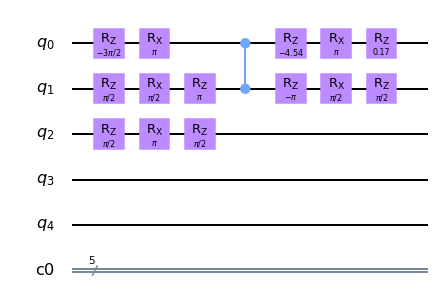

In [12]:
#Simplify the circuit by removing the overhead

#The overhead
#1.rotations with zero angles
#2.double rotation about the same axis (we can combine them)
#3.doublicate cz gates (remove each other)

c3=simplify(c2)
c3.draw(output="mpl")